<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/MaskFormer/Fine-tuning/Fine_tune_MaskFormer_on_an_instance_segmentation_dataset_(ADE20k_full).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune MaskFormer on an instance segmentation dataset

In this notebook, we'll fine-tune MaskFormer on an instance segmentation dataset. MaskFormer is a follow-up work of DETR, capable of solving any image segmentation task (semantic/panoptic/instance) using the same "binary mask classification" paradigm. 

Note that technically the MaskFormer authors didn't release checkpoints for instance segmentation, but it's perfectly doable as shown below.

## Set-up environment

We first install the necessary libraries, which of course include 🤗 libraries. We also install [Albumentations](https://albumentations.ai/) for some data augmentation.

In [1]:
# !pip install -q git+https://github.com/huggingface/transformers.git

In [2]:
# !pip install -q datasets albumentations

## Load dataset

Next, let's load an instance segmentation dataset from the 🤗 hub.

In [3]:
from datasets import load_dataset

dataset = load_dataset("scene_parse_150", "instance_segmentation")

/root/.local/share/virtualenvs/Mask2former-7TinqL9F/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's look at it in more detail. We have 3 splits:

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 20210
    })
    test: Dataset({
        features: ['image', 'annotation'],
        num_rows: 3352
    })
    validation: Dataset({
        features: ['image', 'annotation'],
        num_rows: 2000
    })
})

## Create id2label

It's important to create a mapping between integer IDs and their corresponding label names.

In this case, as noted on the [dataset card](https://huggingface.co/datasets/scene_parse_150), there are 100 semantic categories for the instance segmentation split of the ADE20k dataset. It includes the sentence "See [here](https://github.com/CSAILVision/placeschallenge/blob/master/instancesegmentation/instanceInfo100_train.txt) for an overview".

So we can download this file to get all label names.

In [5]:
# !wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt

Let's read it in using Pandas.

In [6]:
import pandas as pd

data = pd.read_csv('./instanceInfo100_train.txt',
                   sep='\t', header=0)
data.head(5)

,Idx,Object Names,Unnamed: 2,#Inst.,#Pix. per Inst.(*1e3)
0,1,bed,2189,49.06,NaN
1,2,windowpane,8833,10.57,NaN
2,3,cabinet,6727,12.59,NaN
3,4,person,21441,3.47,NaN
4,5,door,4694,11.82,NaN


In [7]:
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
print(id2label)

{0: 'bed', 1: 'windowpane', 2: 'cabinet', 3: 'person', 4: 'door', 5: 'table', 6: 'curtain', 7: 'chair', 8: 'car', 9: 'painting', 10: 'sofa', 11: 'shelf', 12: 'mirror', 13: 'armchair', 14: 'seat', 15: 'fence', 16: 'desk', 17: 'wardrobe', 18: 'lamp', 19: 'bathtub', 20: 'railing', 21: 'cushion', 22: 'box', 23: 'column', 24: 'signboard', 25: 'chest of drawers', 26: 'counter', 27: 'sink', 28: 'fireplace', 29: 'refrigerator', 30: 'stairs', 31: 'case', 32: 'pool table', 33: 'pillow', 34: 'screen door', 35: 'bookcase', 36: 'coffee table', 37: 'toilet', 38: 'flower', 39: 'book', 40: 'bench', 41: 'countertop', 42: 'stove', 43: 'palm', 44: 'kitchen island', 45: 'computer', 46: 'swivel chair', 47: 'boat', 48: 'arcade machine', 49: 'bus', 50: 'towel', 51: 'light', 52: 'truck', 53: 'chandelier', 54: 'awning', 55: 'streetlight', 56: 'booth', 57: 'television receiver', 58: 'airplane', 59: 'apparel', 60: 'pole', 61: 'bannister', 62: 'ottoman', 63: 'bottle', 64: 'van', 65: 'ship', 66: 'fountain', 67: 'w

## Prepare a single example using MaskFormerImageProcessor

Next, let's showcase how a single training example will be prepared for the model.

Note: we won't use the image processor for resizing since it uses Pillow.

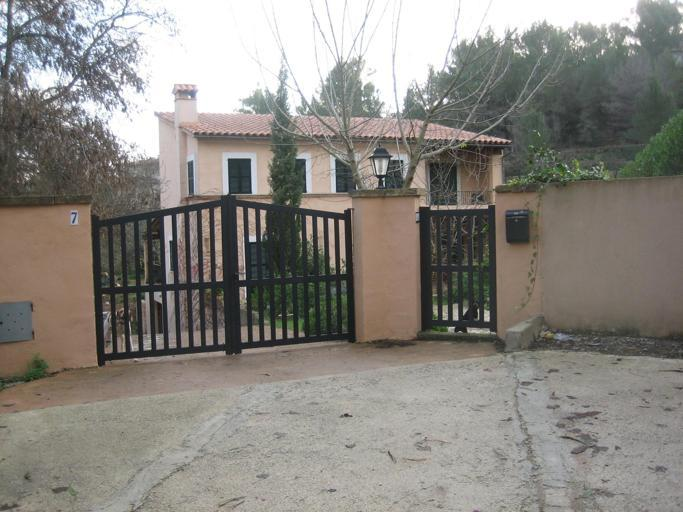

In [8]:
example = dataset['train'][1]
image = example['image']
image

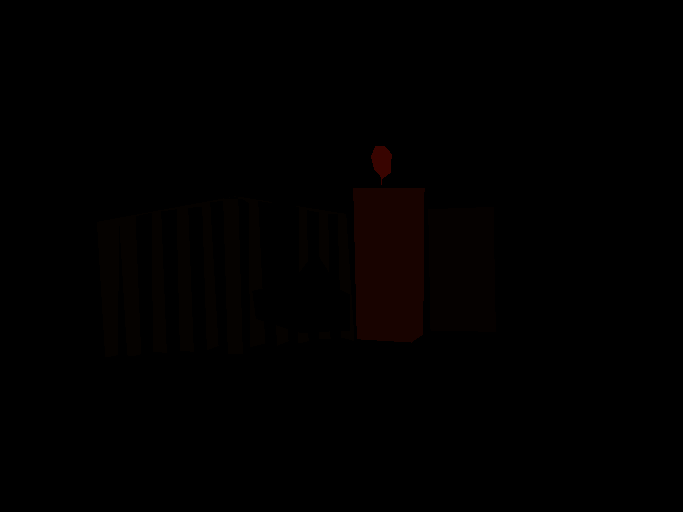

In [9]:
example['annotation']

From the [dataset card](https://huggingface.co/datasets/scene_parse_150):

> Note: in the instance annotation masks, the R(ed) channel encodes category ID, and the G(reen) channel encodes instance ID. Each object instance has a unique instance ID regardless of its category ID. In the dataset, all images have <256 object instances. Refer to this file (train split) and to this file (validation split) for the information about the labels of the 100 semantic categories. To find the mapping between the semantic categories for instance_segmentation and scene_parsing, refer to this file.

In [10]:
import numpy as np

seg = np.array(example['annotation'])
# get green channel
instance_seg = seg[:, :, 1]
instance_seg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
np.unique(instance_seg)

array([0, 1, 2, 3, 4], dtype=uint8)

We can create a mapping between instance IDs and their corresponding semantic category IDs:

In [12]:
instance_seg = np.array(example["annotation"])[:,:,1] # green channel encodes instances
class_id_map = np.array(example["annotation"])[:,:,0] # red channel encodes semantic category
class_labels = np.unique(class_id_map)

# create mapping between instance IDs and semantic category IDs
inst2class = {}
for label in class_labels:
    instance_ids = np.unique(instance_seg[class_id_map == label])
    inst2class.update({i: label for i in instance_ids})
print(inst2class)

{0: 0, 1: 5, 2: 5, 3: 24, 4: 56}


Let's visualize the binary mask of the first instance:

Visualizing instance: door


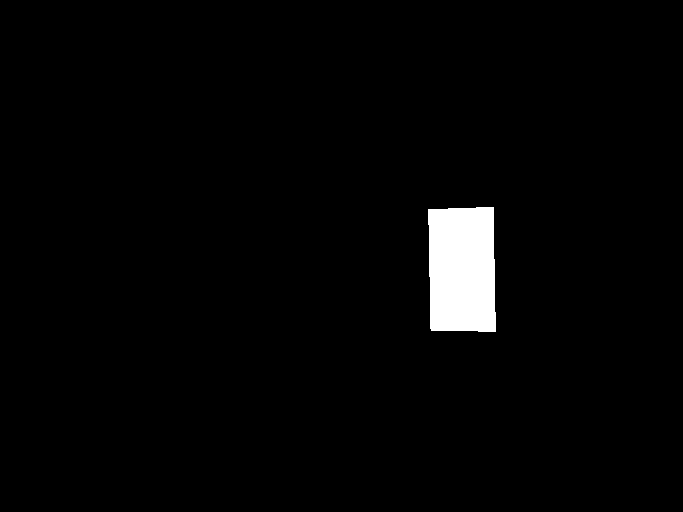

In [13]:
from PIL import Image

print("Visualizing instance:", id2label[inst2class[1] - 1])

# let's visualize the first instance (ignoring background)
mask = (instance_seg == 1)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Let's visualize the binary mask of the second instance:

Visualizing instance: door


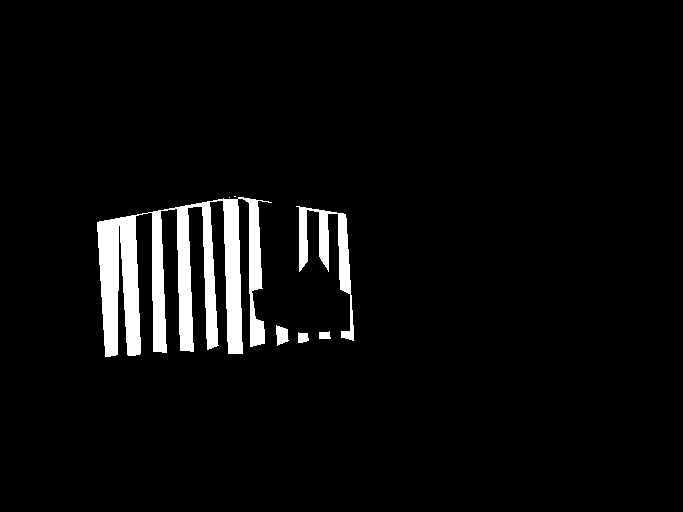

In [14]:
print("Visualizing instance:", id2label[inst2class[2] - 1])

# let's visualize the second instance
mask = (instance_seg == 2)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

We can visualize all masks in one go using the following formula:

In [15]:
R = seg[:, :, 0]
G = seg[:, :, 1]
masks = (R / 10).astype(np.int32) * 256 + (G.astype(np.int32))

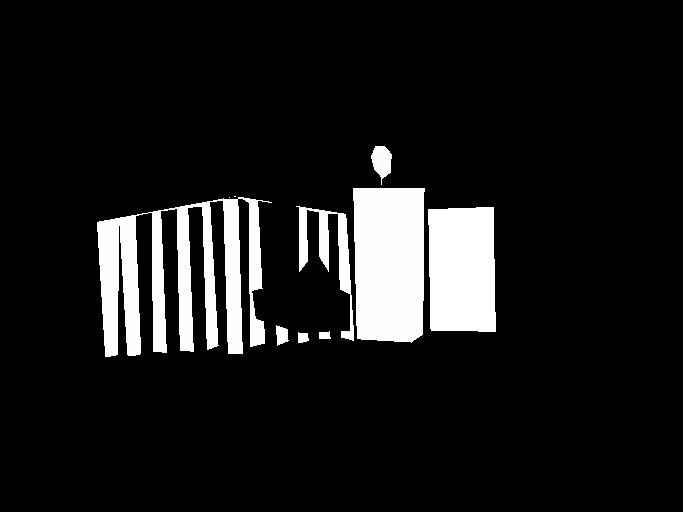

In [16]:
visual_mask = (masks * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Note that for this particular example dataset, different instances don't overlap. However it is technically possible for instance segmentation datasets to have several instances whose masks overlap. But this is not the case here.

Let's show how this image + corresponding set of binary masks gets prepared for the model.

In [17]:
from transformers import Mask2FormerImageProcessor

processor = Mask2FormerImageProcessor(reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

We first apply a resize + normalize operation on the image + mask. Note that normalization only happens on the image, not the mask.

In [18]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

In [19]:
transformed = transform(image=np.array(image), mask=instance_seg)
pixel_values = np.moveaxis(transformed["image"], -1, 0)
instance_seg_transformed = transformed["mask"]
print(pixel_values.shape)
print(instance_seg_transformed.shape)

(3, 512, 512)
(512, 512)


In [20]:
np.unique(instance_seg_transformed)

array([0, 1, 2, 3, 4], dtype=uint8)

Next, we provide those to the image processor, which will turn the single instance segmentation map into a set of binary masks and corresponding labels. This is the format that MaskFormer expects (as it casts any image segmentation task to this format - also called "binary mask classification").

In [21]:
inputs = processor([pixel_values], [instance_seg_transformed], instance_id_to_semantic_id=inst2class, return_tensors="pt")

In [22]:
import torch

for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,[x.shape for x in v])

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
mask_labels [torch.Size([4, 512, 512])]
class_labels [torch.Size([4])]


Let's verify that the different binary masks it creates for a given example are different.

In [23]:
assert not torch.allclose(inputs["mask_labels"][0][0], inputs["mask_labels"][0][1])

Let's check the corresponding class labels.

In [24]:
inputs["class_labels"]

[tensor([ 4,  4, 23, 55])]

Let's visualize one of the binary masks + corresponding label:

Label: door


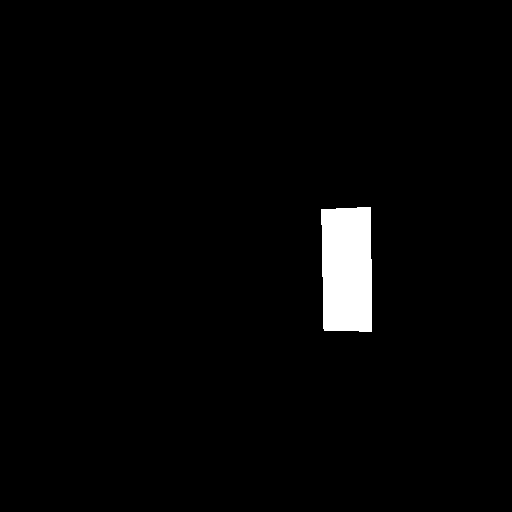

In [25]:
from PIL import Image

# visualize first one
print("Label:", id2label[inputs["class_labels"][0][0].item()])

visual_mask = (inputs["mask_labels"][0][0].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Label: door


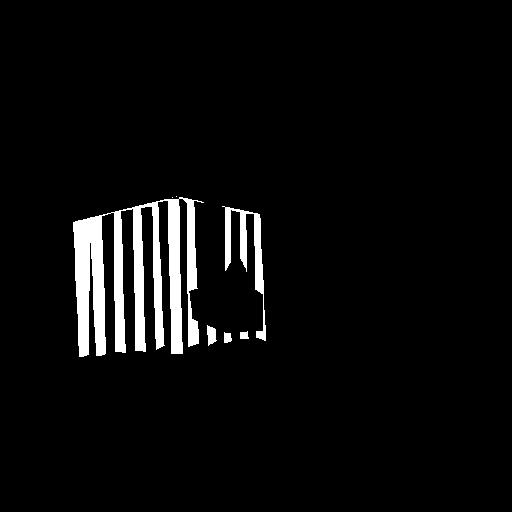

In [26]:
# visualize second one
print("Label:", id2label[inputs["class_labels"][0][1].item()])

visual_mask = (inputs["mask_labels"][0][1].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Label: column


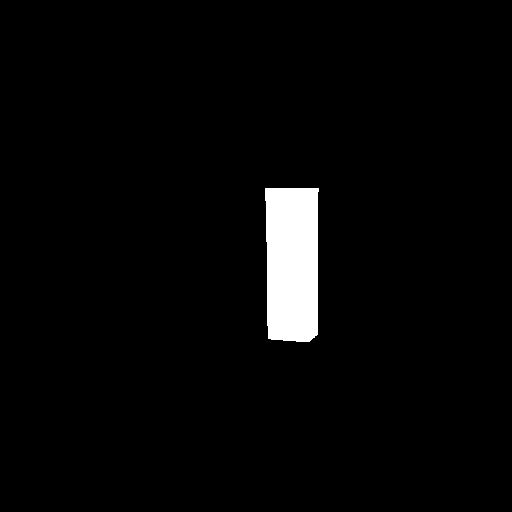

In [27]:
# visualize third one
print("Label:", id2label[inputs["class_labels"][0][2].item()])

visual_mask = (inputs["mask_labels"][0][2].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Label: streetlight


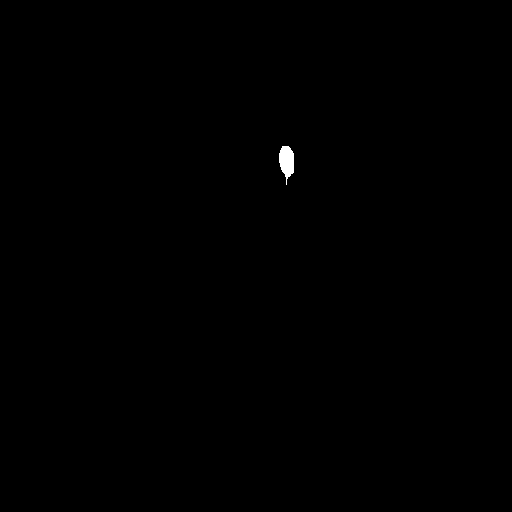

In [28]:
# visualize fourth one
print("Label:", id2label[inputs["class_labels"][0][3].item()])

visual_mask = (inputs["mask_labels"][0][3].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

As can be seen, these look very similar to the ones we visualized initially, except that all images + masks are now of size 512x512 due to the resize operation.

## Create PyTorch Dataset

Now that we've shown how a single example gets prepared, we can define a general PyTorch Dataset. This dataset will return any given training example, entirely prepared for the model.

In [29]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        instance_seg = np.array(self.dataset[idx]["annotation"])[:,:,1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[:,:,0]
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

In [30]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# note that you can include more fancy data augmentation methods here
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = ImageSegmentationDataset(dataset["train"], processor=processor, transform=train_transform)

In [31]:
inputs = train_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
class_labels torch.Size([1])
mask_labels torch.Size([0, 512, 512])


In [32]:
inputs["class_labels"]

tensor([0])

In [33]:
inputs = train_dataset[1]
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])


In [34]:
inputs["class_labels"]

tensor([ 4,  4, 23, 55])

## Create PyTorch DataLoader

Next, one can define a corresponding PyTorch DataLoader, which allows to get batches from the dataset (as neural networks are typically trained in batches for stochastic gradient descent).

We define a custom collate function (which PyTorch allows) to define the logic to batch examples, given by the PyTorch dataset above, together.

In [35]:
from torch.utils.data import DataLoader 

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [36]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
class_labels 4
mask_labels 4


## Verify data (!!)

As always, it's very important to check whether the data which we'll feed to the model makes sense. Let's do some sanity checks.

One of them is denormalizing the pixel values to see whether we still get an image that makes sense.

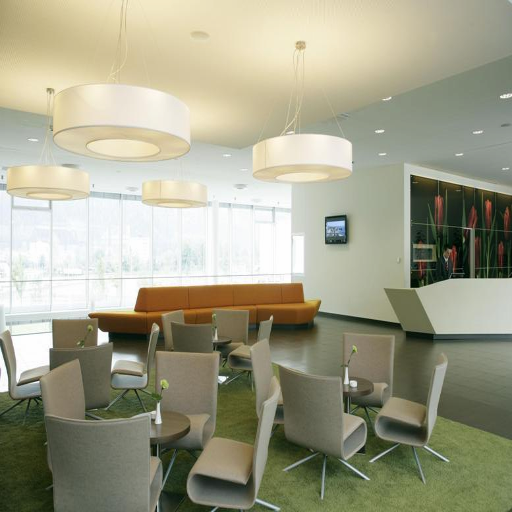

In [37]:
from PIL import Image

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

batch_index = 1

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In this case, there are many class labels it seems.

In [38]:
batch["class_labels"][batch_index]

tensor([ 1,  3,  4,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7, 10, 18, 18, 18, 18, 26, 36, 36, 36, 38, 38, 38, 38, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 57, 88, 88, 88, 88, 94])

In [39]:
id2label[1]

'windowpane'

Let's check the corresponding binary masks. No less than 31 binary masks were created for this example!

In [40]:
batch["mask_labels"][batch_index].shape

torch.Size([48, 512, 512])

Let's visualize a couple of them, see if they make sense.

Visualizing mask for: windowpane


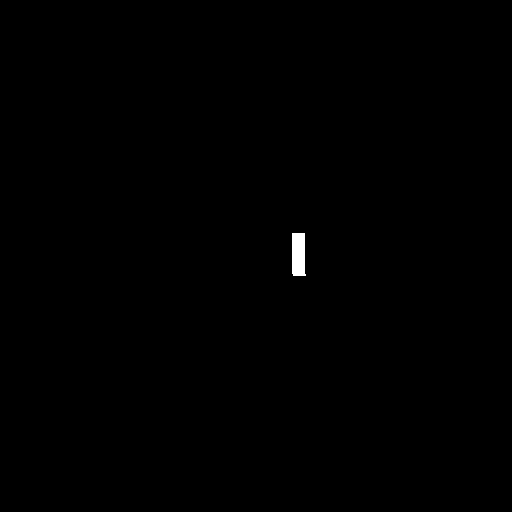

In [41]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

Visualizing mask for: person


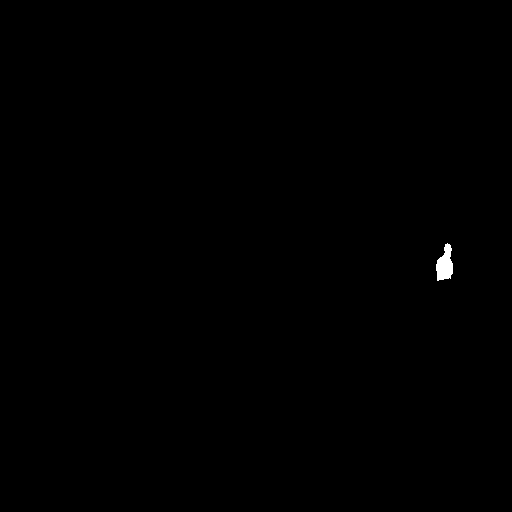

In [42]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][1].item()])

visual_mask = (batch["mask_labels"][batch_index][1].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

## Define the model

Next, let's define the model. Here we will only replace the classification head with a new one, all other parameters will use pre-trained ones.

Note that we're loading a [checkpoint](https://huggingface.co/facebook/maskformer-swin-base-ade) of MaskFormer fine-tuned on a semantic segmentation dataset, but that's ok, it will work fine when fine-tuning on an instance segmentation dataset.

We'll load a checkpoint with a Swin backbone as these are pretty strong.

In [43]:
from transformers import Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-instance",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-cityscapes-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([101]) in the model instantiated
- class_predictor.weight: found shape torch.Size([9, 256]) in the checkpoint and torch.Size([101, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([9]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

## Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [44]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
class_labels 4
mask_labels 4


In [45]:
print([label.shape for label in batch["class_labels"]])

[torch.Size([8]), torch.Size([2]), torch.Size([5]), torch.Size([21])]


In [46]:
print([label.shape for label in batch["mask_labels"]])

[torch.Size([8, 512, 512]), torch.Size([2, 512, 512]), torch.Size([5, 512, 512]), torch.Size([21, 512, 512])]


In [47]:
outputs = model(
          pixel_values=batch["pixel_values"],
          mask_labels=batch["mask_labels"],
          class_labels=batch["class_labels"],
      )
outputs.loss

tensor(120.9185, grad_fn=<AddBackward0>)

## Train the model

Let's train the model in familiar PyTorch fashion.

In [48]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  # After each epoch, save the model
  torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
  print(f"Model saved as model_epoch_{epoch}.pth")

Epoch: 0


  0%|          | 0/5053 [00:00<?, ?it/s]

Loss: 38.19517517089844


  2%|▏         | 101/5053 [05:33<3:58:10,  2.89s/it]

Loss: 25.56124981795207


  4%|▍         | 201/5053 [10:23<3:54:06,  2.90s/it]

Loss: 23.490461060063755


  6%|▌         | 301/5053 [15:12<3:50:31,  2.91s/it]

Loss: 22.231034571942303


  8%|▊         | 401/5053 [20:03<3:43:36,  2.88s/it]

Loss: 21.59687101097773


 10%|▉         | 501/5053 [24:53<3:37:59,  2.87s/it]

Loss: 20.992135281096438


 12%|█▏        | 601/5053 [29:44<3:34:54,  2.90s/it]

Loss: 20.580754948931805


 14%|█▍        | 701/5053 [34:35<3:33:27,  2.94s/it]

Loss: 20.19741502331939


 16%|█▌        | 801/5053 [39:25<3:25:33,  2.90s/it]

Loss: 19.846529008743914


 18%|█▊        | 901/5053 [44:15<3:19:39,  2.89s/it]

Loss: 19.568625905802193


 20%|█▉        | 1001/5053 [49:05<3:14:37,  2.88s/it]

Loss: 19.26294799713226


 22%|██▏       | 1101/5053 [53:56<3:12:15,  2.92s/it]

Loss: 19.069624174085128


 24%|██▍       | 1201/5053 [58:46<3:04:39,  2.88s/it]

Loss: 18.881756157601107


 26%|██▌       | 1301/5053 [1:03:38<3:05:10,  2.96s/it]

Loss: 18.717798017887407


 28%|██▊       | 1401/5053 [1:08:28<2:58:25,  2.93s/it]

Loss: 18.56721820701964


 30%|██▉       | 1501/5053 [1:13:19<2:51:44,  2.90s/it]

Loss: 18.402234467881907


 32%|███▏      | 1601/5053 [1:18:09<2:51:27,  2.98s/it]

Loss: 18.220082868269873


 34%|███▎      | 1701/5053 [1:23:00<2:41:34,  2.89s/it]

Loss: 18.10241230931582


 36%|███▌      | 1801/5053 [1:27:50<2:36:32,  2.89s/it]

Loss: 17.952033503594365


 38%|███▊      | 1901/5053 [1:32:41<2:33:57,  2.93s/it]

Loss: 17.84839886129059


 40%|███▉      | 2001/5053 [1:37:32<2:28:13,  2.91s/it]

Loss: 17.75113017626967


 42%|████▏     | 2101/5053 [1:42:22<2:23:01,  2.91s/it]

Loss: 17.641277963464912


 44%|████▎     | 2201/5053 [1:47:11<2:17:26,  2.89s/it]

Loss: 17.509177671785196


 46%|████▌     | 2301/5053 [1:52:00<2:11:55,  2.88s/it]

Loss: 17.383305484136773


 48%|████▊     | 2401/5053 [1:56:50<2:07:37,  2.89s/it]

Loss: 17.278616532838527


 49%|████▉     | 2501/5053 [2:01:39<2:03:03,  2.89s/it]

Loss: 17.1745241680702


 51%|█████▏    | 2601/5053 [2:06:29<1:56:43,  2.86s/it]

Loss: 17.07871091535393


 53%|█████▎    | 2701/5053 [2:11:20<1:56:05,  2.96s/it]

Loss: 16.991793993357067


 55%|█████▌    | 2801/5053 [2:16:09<1:48:09,  2.88s/it]

Loss: 16.89096113291437


 57%|█████▋    | 2901/5053 [2:21:00<1:44:02,  2.90s/it]

Loss: 16.809617876061402


 59%|█████▉    | 3001/5053 [2:25:52<1:40:19,  2.93s/it]

Loss: 16.729518765650045


 61%|██████▏   | 3101/5053 [2:30:43<1:34:50,  2.92s/it]

Loss: 16.657375795615945


 63%|██████▎   | 3201/5053 [2:35:33<1:30:28,  2.93s/it]

Loss: 16.576571372776097


 65%|██████▌   | 3301/5053 [2:40:24<1:23:51,  2.87s/it]

Loss: 16.498798770349843


 67%|██████▋   | 3401/5053 [2:45:14<1:19:53,  2.90s/it]

Loss: 16.424872276958947


 69%|██████▉   | 3501/5053 [2:50:04<1:14:55,  2.90s/it]

Loss: 16.362595414611416


 71%|███████▏  | 3601/5053 [2:54:54<1:10:22,  2.91s/it]

Loss: 16.27547475610366


 73%|███████▎  | 3701/5053 [2:59:43<1:05:23,  2.90s/it]

Loss: 16.210190642237567


 75%|███████▌  | 3801/5053 [3:04:32<1:00:36,  2.90s/it]

Loss: 16.136128209948822


 77%|███████▋  | 3901/5053 [3:09:22<55:46,  2.91s/it]  

Loss: 16.069432971417


 79%|███████▉  | 4001/5053 [3:14:11<50:57,  2.91s/it]

Loss: 15.998223537923216


 81%|████████  | 4101/5053 [3:19:01<46:09,  2.91s/it]

Loss: 15.937626466551109


 83%|████████▎ | 4201/5053 [3:23:50<40:27,  2.85s/it]

Loss: 15.874429128590553


 85%|████████▌ | 4301/5053 [3:28:40<35:44,  2.85s/it]

Loss: 15.819690633612826


 87%|████████▋ | 4401/5053 [3:33:30<31:19,  2.88s/it]

Loss: 15.765400226591284


 89%|████████▉ | 4501/5053 [3:38:19<27:04,  2.94s/it]

Loss: 15.711985675262573


 91%|█████████ | 4601/5053 [3:43:10<21:41,  2.88s/it]

Loss: 15.655323934254504


 93%|█████████▎| 4701/5053 [3:48:00<17:10,  2.93s/it]

Loss: 15.595768157128855


 95%|█████████▌| 4801/5053 [3:52:49<12:17,  2.93s/it]

Loss: 15.5384706492425


 97%|█████████▋| 4901/5053 [3:57:40<07:19,  2.89s/it]

Loss: 15.495097645251903


 99%|█████████▉| 5001/5053 [4:02:30<02:29,  2.88s/it]

Loss: 15.447137152521735


100%|██████████| 5053/5053 [4:04:59<00:00,  2.91s/it]


Model saved as model_epoch_0.pth
Epoch: 1


  0%|          | 1/5053 [00:02<4:03:26,  2.89s/it]

Loss: 15.429237524998628


  2%|▏         | 101/5053 [04:53<3:56:56,  2.87s/it]

Loss: 15.381500931337593


  4%|▍         | 201/5053 [09:43<3:54:18,  2.90s/it]

Loss: 15.328024030696135


  6%|▌         | 301/5053 [14:33<3:48:14,  2.88s/it]

Loss: 15.289340471880681


  8%|▊         | 401/5053 [19:23<3:44:30,  2.90s/it]

Loss: 15.235331627497853


 10%|▉         | 501/5053 [24:12<3:38:14,  2.88s/it]

Loss: 15.19055586822007


 12%|█▏        | 601/5053 [29:01<3:37:21,  2.93s/it]

Loss: 15.140418520359205


 14%|█▍        | 701/5053 [33:52<3:30:05,  2.90s/it]

Loss: 15.093861770472415


 16%|█▌        | 801/5053 [38:43<3:24:50,  2.89s/it]

Loss: 15.050564148001028


 18%|█▊        | 901/5053 [43:33<3:20:39,  2.90s/it]

Loss: 15.006836548173538


 20%|█▉        | 1001/5053 [48:25<3:17:24,  2.92s/it]

Loss: 14.969469236128296


 22%|██▏       | 1101/5053 [53:16<3:09:26,  2.88s/it]

Loss: 14.930794388755636


 24%|██▍       | 1201/5053 [58:06<3:05:01,  2.88s/it]

Loss: 14.884208175521623


 26%|██▌       | 1301/5053 [1:02:56<2:59:46,  2.87s/it]

Loss: 14.842836143631446


 28%|██▊       | 1401/5053 [1:07:47<2:56:32,  2.90s/it]

Loss: 14.805814701110469


 30%|██▉       | 1501/5053 [1:12:37<2:51:16,  2.89s/it]

Loss: 14.768747098551213


 32%|███▏      | 1601/5053 [1:17:28<2:47:21,  2.91s/it]

Loss: 14.736527949546973


 34%|███▎      | 1701/5053 [1:22:17<2:41:15,  2.89s/it]

Loss: 14.70322744447597


 36%|███▌      | 1801/5053 [1:27:07<2:36:28,  2.89s/it]

Loss: 14.665267898555117


 38%|███▊      | 1901/5053 [1:31:57<2:31:21,  2.88s/it]

Loss: 14.632796666928522


 40%|███▉      | 2001/5053 [1:36:46<2:25:16,  2.86s/it]

Loss: 14.600136841603424


 42%|████▏     | 2101/5053 [1:41:34<2:21:49,  2.88s/it]

Loss: 14.55960448146358


 44%|████▎     | 2201/5053 [1:46:25<2:18:30,  2.91s/it]

Loss: 14.527676105795093


 46%|████▌     | 2301/5053 [1:51:15<2:12:48,  2.90s/it]

Loss: 14.490221569748376


 48%|████▊     | 2401/5053 [1:56:05<2:08:24,  2.91s/it]

Loss: 14.462524584043896


 49%|████▉     | 2501/5053 [2:00:56<2:03:31,  2.90s/it]

Loss: 14.43757402001253


 51%|█████▏    | 2601/5053 [2:05:45<1:57:33,  2.88s/it]

Loss: 14.401268006056428


 53%|█████▎    | 2701/5053 [2:10:36<1:53:54,  2.91s/it]

Loss: 14.370337506561958


 55%|█████▌    | 2801/5053 [2:15:26<1:50:29,  2.94s/it]

Loss: 14.338942129895667


 57%|█████▋    | 2901/5053 [2:20:17<1:44:45,  2.92s/it]

Loss: 14.30758159848726


 59%|█████▉    | 3001/5053 [2:25:06<1:40:15,  2.93s/it]

Loss: 14.276061370207431


 61%|██████▏   | 3101/5053 [2:29:56<1:33:34,  2.88s/it]

Loss: 14.248127234079313


 63%|██████▎   | 3201/5053 [2:34:46<1:29:26,  2.90s/it]

Loss: 14.22082125947774


 65%|██████▌   | 3301/5053 [2:39:37<1:24:24,  2.89s/it]

Loss: 14.19333088517139


 67%|██████▋   | 3401/5053 [2:44:27<1:19:59,  2.91s/it]

Loss: 14.16953318636725


 69%|██████▉   | 3501/5053 [2:49:15<1:14:20,  2.87s/it]

Loss: 14.140162691379016


 71%|███████▏  | 3601/5053 [2:54:04<1:11:00,  2.93s/it]

Loss: 14.111465567270143


 72%|███████▏  | 3623/5053 [2:55:08<1:08:29,  2.87s/it]

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of the training set.

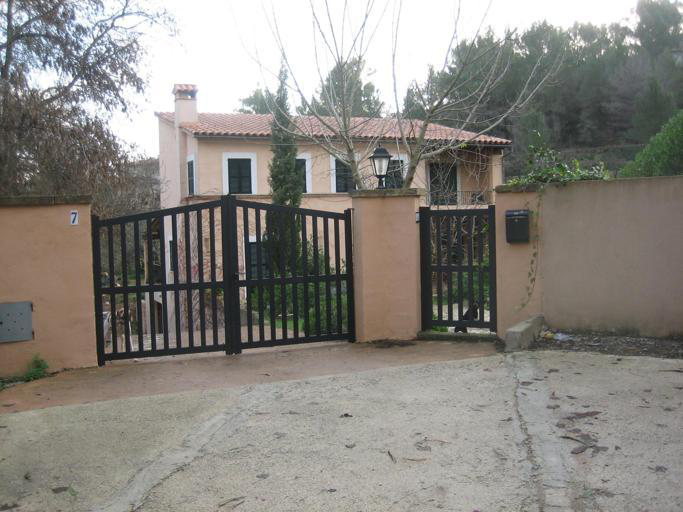

In [ ]:
example = dataset['train'][1]
image = example['image']
image

In [ ]:
from transformers import Mask2FormerImageProcessor

processor = Mask2FormerImageProcessor()

In [ ]:
# prepare image for the model
inputs = processor(image, return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 800, 1088])
pixel_mask torch.Size([1, 800, 1088])


In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

The predictions include 2 things, a predicted segmentation map and a corresponding segments_info, which includes more information about the segments of the map.

In [ ]:
# you can pass them to processor for postprocessing
results = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(results.keys())

dict_keys(['segmentation', 'segments_info'])


In [ ]:
for segment in results['segments_info']:
  print(segment)

{'id': 1, 'label_id': 55, 'was_fused': False, 'score': 0.953546}
{'id': 2, 'label_id': 4, 'was_fused': False, 'score': 0.869784}
{'id': 3, 'label_id': 91, 'was_fused': False, 'score': 0.82259}
{'id': 4, 'label_id': 40, 'was_fused': False, 'score': 0.602312}


Let's visualize the predicted binary masks of the segments:

In [ ]:
import numpy as np

def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

Visualizing mask for instance: streetlight


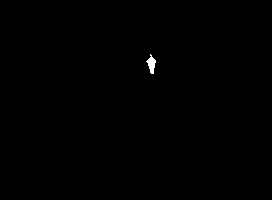

------
Visualizing mask for instance: door


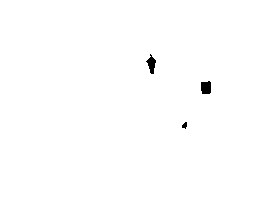

------
Visualizing mask for instance: ashcan


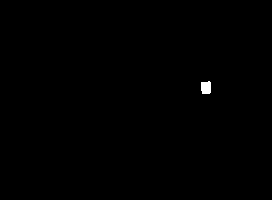

------
Visualizing mask for instance: bench


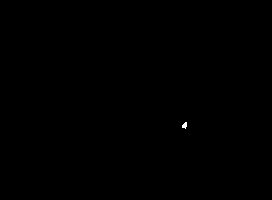

------


In [ ]:
for segment in results['segments_info']:
    print("Visualizing mask for instance:", model.config.id2label[segment['label_id']])
    mask = get_mask(results['segmentation'], segment['id'])
    display(mask)
    print("------")

This doesn't seem too bad even though we only trained the model for a single epoch.

I'd recommend checking out the MaskFormer paper for training details, like number of epochs, learning rate etc.